In [1]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
from collections import Counter
from data_science_toolkit.data_visualization import get_fig_ax, visualize_class_distribution, top_n_tokens_plot_from_counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize 
# Stealing stuff... http://brandonrose.org/clustering
from nltk.stem.snowball import SnowballStemmer
import nltk, re
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora, models, similarities 
from data_science_toolkit.association_rules import apriori_with_df
from data_science_toolkit.data_visualization import generate_histogram

In [2]:
output_col = 'above_monthly_avg'
# file_name = 'trump_tweets_sp500.csv'
file_name = 'elonmusk_twint_preprocessed.csv'

In [3]:
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [4]:
stop_words = set(stopwords.words('english')).union({'', 'would'})
# , '-', '&', '"', ':', '/'
stemmer = SnowballStemmer("english")

In [5]:
stock_tweet = pd.read_csv('./stocks/{}'.format(file_name))
stock_tweet['created_at']= pd.to_datetime(stock_tweet['created_at']) 

In [6]:
stock_tweet.head(2)

,text,retweet_count,retweet,num_videos,created_at,preprocessed_text,created_hour,dow,num_links,num_words,num_photos,above_monthly_avg,percent_caps,num_hashtags,num_mentions
0,"Please ignore prior tweets, as that was someone pretending to be me :) This is actually me.",122,False,0,2010-06-04 14:31:57,"please ignore prior tweets , as that was someone pretending to be me : ) this is actually me .",14,4,0,16,0,0,0.0,0,0
1,"Went to Iceland on Sat to ride bumper cars on ice! No, not the country, Vlad's rink in Van Nuys. Awesome family fun :) pic.twitter.com/rBQXJ9IT",17,False,0,2011-12-01 04:55:11,"went to iceland on sat to ride bumper cars on ice ! no , not the country , vlad 's rink in van nuys . awesome family fun : ) twitpicture",4,3,0,25,1,0,0.0,0,0


In [7]:
since_election = stock_tweet[stock_tweet["created_at"] > datetime(2016, 11, 8)]

In [8]:
prep_all_tweets = stock_tweet["preprocessed_text"].tolist()
prep_tweets_since_election = since_election["preprocessed_text"].tolist()

In [9]:
prep_tweets_since_election

['love you too ! msciurl ...',
 'we could enable that , although the cameras use grey , grey , grey , red detection , so it would look a little greyish red : )',
 "wow , thanks . we wo n't let you down .",
 'looks like the model s p100d easter egg will allow it to do 0 to 60 mph in 2.4 sec and a 10.6 sec 1/4 mile via software update next month',
 'model x numbers should also improve by 0.1 sec on 0 to 60 and 1/4 mile',
 'all p100d vehicles produced to date , as well as new . this is purely a software optimization .',
 'sounds right',
 'vote tally shows ~85 % of unaffiliated shareholders in favor of the tesla/solarcity merger ! thanks for believing .',
 'big mobile app update coming with 8.1 next month',
 "consequences of population implosion greatly underestimated . upside down demographic pyramid ca n't support social services .",
 'tesla self-driving ai with the benny hill option package msciurl ...',
 '-2',
 'yes',
 'that and paint it black will both be uploaded for free as easter (

# 1.0 Class Distribution

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


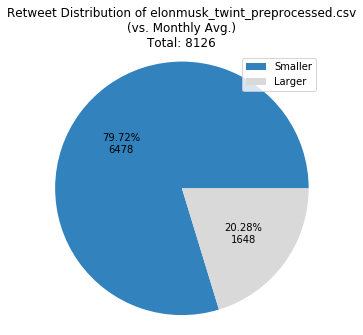

In [10]:
fig, ax = get_fig_ax(1, 1, 5, 5)
ax = visualize_class_distribution(stock_tweet[output_col], 
                                  given_title="Retweet Distribution of {}\n(vs. Monthly Avg.)".format(file_name), 
                                  given_label_titles={1: "Larger", 0:"Smaller"}, axes=ax, row_idx=0, col_idx=0)

## 1.1 Class Distribution since Election

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


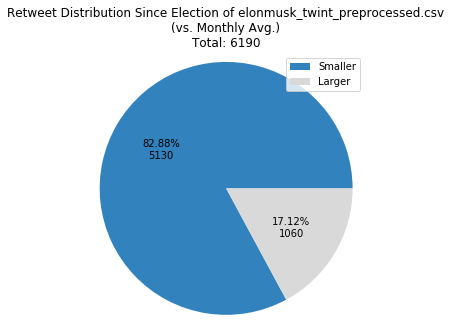

In [11]:
fig, ax = get_fig_ax(1, 1, 5, 5)
ax = visualize_class_distribution(since_election[output_col], 
                                  given_title="Retweet Distribution Since Election of {}\n(vs. Monthly Avg.)".format(file_name), 
                                  given_label_titles={1: "Larger", 0:"Smaller"}, axes=ax, row_idx=0, col_idx=0)

# 2.0 Most Common Words

In [12]:
def filtered_word_array(tweet, words_to_ignore={}):
    return [x for x in tweet.split(' ') if x not in stop_words.union(words_to_ignore) and re.search('[a-zA-Z]', x)]

In [13]:
stock_tweet.iloc[3500]

text                 😉                  
retweet_count        121                
retweet              False              
num_videos           0                  
created_at           2018-04-27 21:32:14
preprocessed_text    winkingface        
created_hour         21                 
dow                  4                  
num_links            0                  
num_words            1                  
num_photos           0                  
above_monthly_avg    0                  
percent_caps         0                  
num_hashtags         0                  
num_mentions         0                  
Name: 3500, dtype: object

In [14]:
prep_all_tweets[3500]

'winkingface'

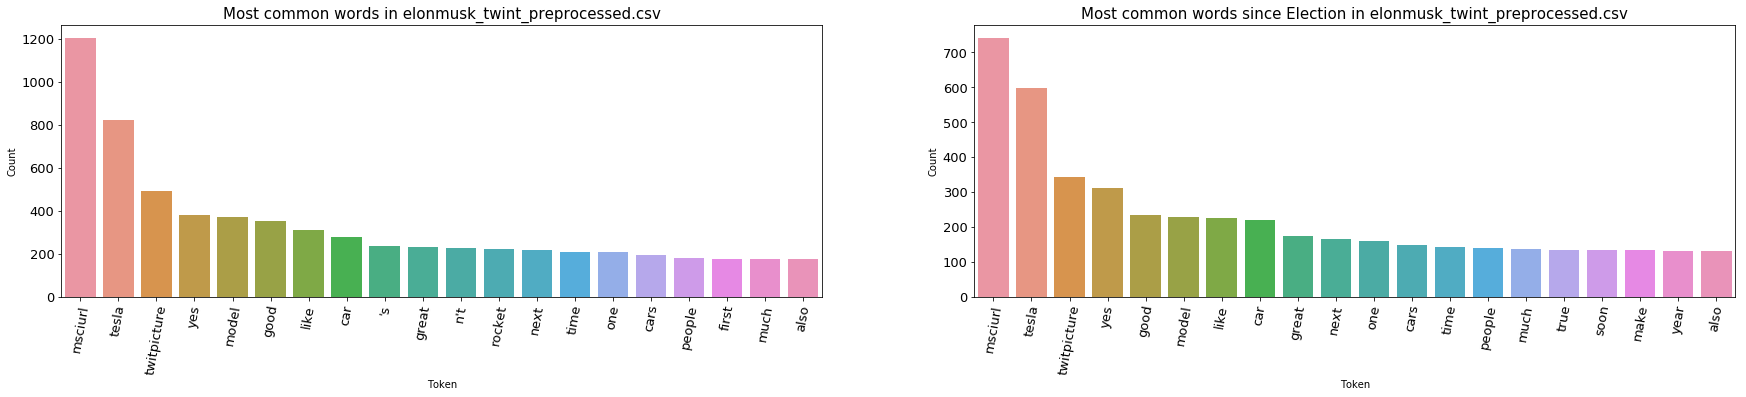

In [15]:
fig, ax = get_fig_ax(1, 2, 15, 5)
ax = top_n_tokens_plot_from_counter(Counter([x for x in filtered_word_array(' '.join(prep_all_tweets))]), 
                                    20, ax, 0, 0, "Most common words in {}".format(file_name))
ax = top_n_tokens_plot_from_counter(Counter([x for x in filtered_word_array(' '.join(prep_tweets_since_election))]), 
                                    20, ax, 0, 1, "Most common words since Election in {}".format(file_name))

## 2.1 Most Common Words (Larger vs Smaller than monthly average)

In [16]:
above_avg = stock_tweet[stock_tweet[output_col] == 1]
above_avg_since_election = since_election[since_election[output_col] == 1]
below_avg = stock_tweet[stock_tweet[output_col] == 0]
below_avg_since_election = since_election[since_election[output_col] == 0]

In [17]:
def get_count_no_sw(df):
    return Counter(filtered_word_array(' '.join(df['preprocessed_text'].tolist())))

In [18]:
above_not_below = get_count_no_sw(above_avg) - get_count_no_sw(below_avg)
above_not_below_since_election = get_count_no_sw(above_avg_since_election) - get_count_no_sw(below_avg_since_election)
below_not_above = get_count_no_sw(below_avg) - get_count_no_sw(above_avg)
below_not_above_since_election = get_count_no_sw(below_avg_since_election) - get_count_no_sw(above_avg_since_election)

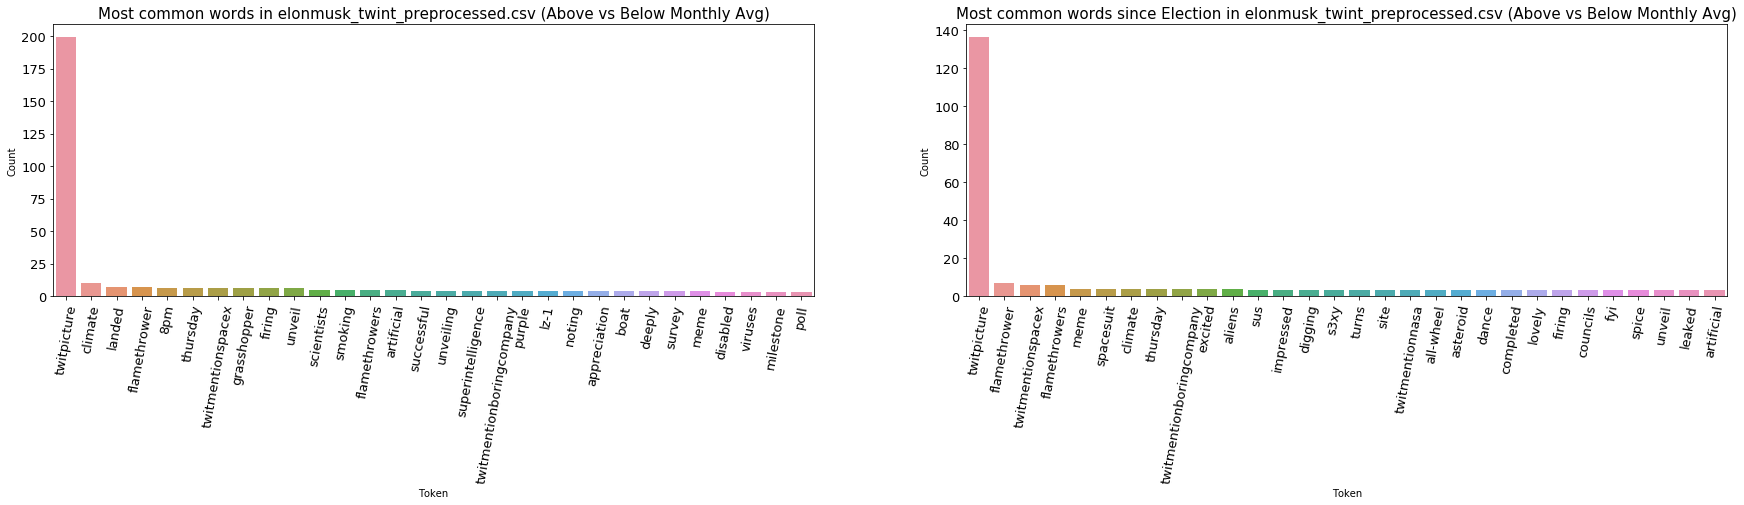

In [19]:
fig, ax = get_fig_ax(1, 2, 15, 5)
ax = top_n_tokens_plot_from_counter(above_not_below, 30, ax, 0, 0, 
                                    "Most common words in {} (Above vs Below Monthly Avg)".format(file_name))
ax = top_n_tokens_plot_from_counter(above_not_below_since_election, 30, ax, 0, 1, 
                                    "Most common words since Election in {} (Above vs Below Monthly Avg)".format(file_name))

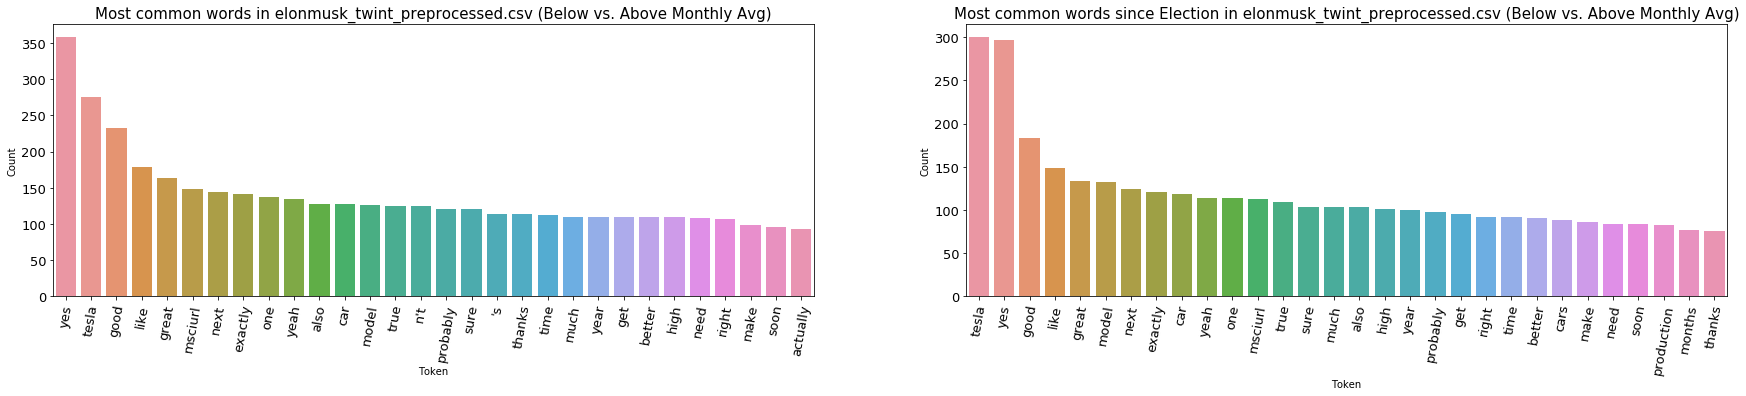

In [20]:
fig, ax = get_fig_ax(1, 2, 15, 5)
ax = top_n_tokens_plot_from_counter(below_not_above, 30, ax, 0, 0, 
                                    "Most common words in {} (Below vs. Above Monthly Avg)".format(file_name))
ax = top_n_tokens_plot_from_counter(below_not_above_since_election, 30, ax, 0, 1, 
                                    "Most common words since Election in {} (Below vs. Above Monthly Avg)".format(file_name))

# K-Means Clustering for Common Topics

Summarize this but don't need to say much else

Ran out of memory trying to do this for all Trump tweets - I'm only going to do it for tweets since the election.  
Elbow method: https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

# 3.0 Apriori - Featuresets
- Due to the small number of tweets, etc, we need to use a relatively low support of 0.02 before starting to look for rules

In [21]:
def prep_fn(text):
    text = text.split(" ")
    final = []
    for word in text:
        if re.search('[a-zA-Z]', word) and word not in stop_words:
            final.append(word)
    return final

In [22]:
frequent_itemsets = apriori_with_df(prep_tweets_since_election, prep_fn, min_support=0.02, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.021002,(also)
1,0.032633,(car)
2,0.021971,(cars)
3,0.037480,(good)
4,0.026817,(great)
5,0.020355,(high)
6,0.034410,(like)
7,0.020840,(make)
8,0.033118,(model)
9,0.116801,(msciurl)


## Using these frequent itemsets, we can come up with association rules:

In [23]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


## We can use these itemsets as inputs to our SVM

# WILL NEED TO MOVE THIS INTO THE CROSS VALIDATION PIPELINE!!!

In [24]:
above_avg_apr = apriori_with_df(since_election[since_election[output_col] == 1]['preprocessed_text'].tolist(), prep_fn).values.tolist()
above_avg_apr_dict = {x[1]: x[0] for x in above_avg_apr if len(x[1]) > 1}
above_avg_apr_set = set([x[1] for x in above_avg_apr])

In [25]:
below_avg_apr = apriori_with_df(since_election[since_election[output_col] == 0]['preprocessed_text'], prep_fn).values.tolist()
below_avg_apr_dict = {x[1]: x[0] for x in below_avg_apr if len(x[1]) > 1}
below_avg_apr_set = set([x[1] for x in below_avg_apr])

In [26]:
below_avg_apr_dict

{}

In [27]:
above_avg_apr_diff = Counter(above_avg_apr_dict) - Counter(below_avg_apr_dict)

In [28]:
below_avg_apr_diff = Counter(below_avg_apr_dict) - Counter(above_avg_apr_dict)

In [29]:
below_avg_apr_diff.items()

dict_items([])

In [30]:
above_avg_apr_feats = sorted([x for x in above_avg_apr_diff.most_common(4) if x[1] > 0.04], key=lambda x: x[1], reverse=True)
below_avg_apr_feats = sorted([x for x in below_avg_apr_diff.most_common(4) if x[1] > 0.04], key=lambda x: x[1], reverse=True)

In [31]:
above_avg_apr_feats

[(frozenset({'msciurl', 'tesla'}), 0.04339622641509434)]

In [32]:
# feat = above_avg_apr_feats[0]

In [33]:
def contains_feature(tweets, feat):
    contains_feat_list = []
    for tweet in tweets:
        curr_set = [1 if word in set(tweet) else 0 for word in feat]
#         print(feat, curr_set)
#         print(ting)
        contains_feat_list.append(min(curr_set))
    return contains_feat_list

In [34]:
tweets = list(map(lambda x: x.split(" "), prep_tweets_since_election))

In [35]:
for feat in above_avg_apr_feats:
    col_name = "above_avg_apr_{}".format('_'.join(feat[0]))
    since_election[col_name] = contains_feature(tweets, feat[0])
    since_election[col_name] = since_election[col_name].astype('category')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [36]:
for feat in below_avg_apr_feats:
    col_name = "below_avg_apr_{}".format('_'.join(feat[0]))
    since_election[col_name] = contains_feature(tweets, feat[0])
    since_election[col_name] = since_election[col_name].astype('category')

In [37]:
since_election.columns

Index(['text', 'retweet_count', 'retweet', 'num_videos', 'created_at',
       'preprocessed_text', 'created_hour', 'dow', 'num_links', 'num_words',
       'num_photos', 'above_monthly_avg', 'percent_caps', 'num_hashtags',
       'num_mentions', 'above_avg_apr_msciurl_tesla'],
      dtype='object')

### 3.something Kmeans
- https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e

In [38]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [113]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(list(map(lambda x: x.split(" "), prep_tweets_since_election)))]
model = Doc2Vec(documents, vector_size=200, window=2, min_count=1, workers=4)

In [114]:
model.train(documents, total_examples=model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [115]:
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_check_input_data_sanity',
 '_check_training_sanity',
 '_clear_post_train',
 '_do_train_epoch',
 '_do_train_job',
 '_get_job_params',
 '_get_offsets_and_start_doctags_for_corpusfile',
 '_get_thread_working_mem',
 '_job_producer',
 '_load_specials',
 '_log_epoch_end',
 '_log_epoch_progress',
 '_log_progress',
 '_log_train_end',
 '_raw_word_count',
 '_save_specials',
 '_set_train_params',
 '_smart_save',
 '_train_epoch',
 '_train_epoch_corpusfile',
 '_update_job_params',
 '_worker_loop',
 '_worker_loop_corpusfile',
 'alpha',
 'batch_words',
 'build_vocab',
 'build_vocab_from_freq',
 'callbacks',
 'cbow_mean'

In [116]:
model.docvecs.doctag_syn0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """Entry point for launching an IPython kernel.


array([[ 0.00302922, -0.00341429, -0.00056214, ...,  0.00073714,
        -0.0020592 ,  0.00168714],
       [ 0.02600208, -0.15032789,  0.00758483, ..., -0.03186317,
        -0.10645992,  0.03285793],
       [ 0.00994083, -0.06112393,  0.00554804, ..., -0.01032351,
        -0.04379119,  0.01503469],
       ...,
       [ 0.00238252, -0.01902576,  0.00173552, ..., -0.00501693,
        -0.01210407,  0.00323013],
       [ 0.00360406, -0.01539728,  0.00211088, ..., -0.00250344,
        -0.0136219 ,  0.00279087],
       [ 0.00881264, -0.05816129,  0.00150084, ..., -0.01168805,
        -0.04113154,  0.01319342]], dtype=float32)

In [117]:
from sklearn.externals import joblib
from sklearn.cluster import KMeans
def kmeans(num_clusters, term_matrix):
    km = KMeans(n_clusters=num_clusters, max_iter=1000000, n_jobs=6, n_init=30)
    labels = km.fit_predict(term_matrix)
#     centroids = km.cluster_centers_
    return km, labels, km.inertia_

In [118]:
def tokenize_only(tweet):
    return [x for x in tweet.split(" ") if re.search('[a-zA-Z]', x) and x not in stop_words.union({'msciurl', 'twitpicture', "'s'"})]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.


Iter: 2 , Num Iter:  9 Inertia:  982.239464172372
Iter: 4 , Num Iter:  24 Inertia:  293.26296485681104
Iter: 8 , Num Iter:  31 Inertia:  85.57802028228787
Iter: 10 , Num Iter:  36 Inertia:  58.558133491836735
Iter: 20 , Num Iter:  78 Inertia:  17.36068139852639
Iter: 30 , Num Iter:  26 Inertia:  8.990936263860371
Iter: 40 , Num Iter:  47 Inertia:  6.108284756862812
Iter: 50 , Num Iter:  40 Inertia:  4.840912706052196
Iter: 60 , Num Iter:  22 Inertia:  4.129894537144569
Iter: 70 , Num Iter:  25 Inertia:  3.7183875333423617
Iter: 80 , Num Iter:  41 Inertia:  3.4251688856717997
Iter: 90 , Num Iter:  29 Inertia:  3.233277182897276


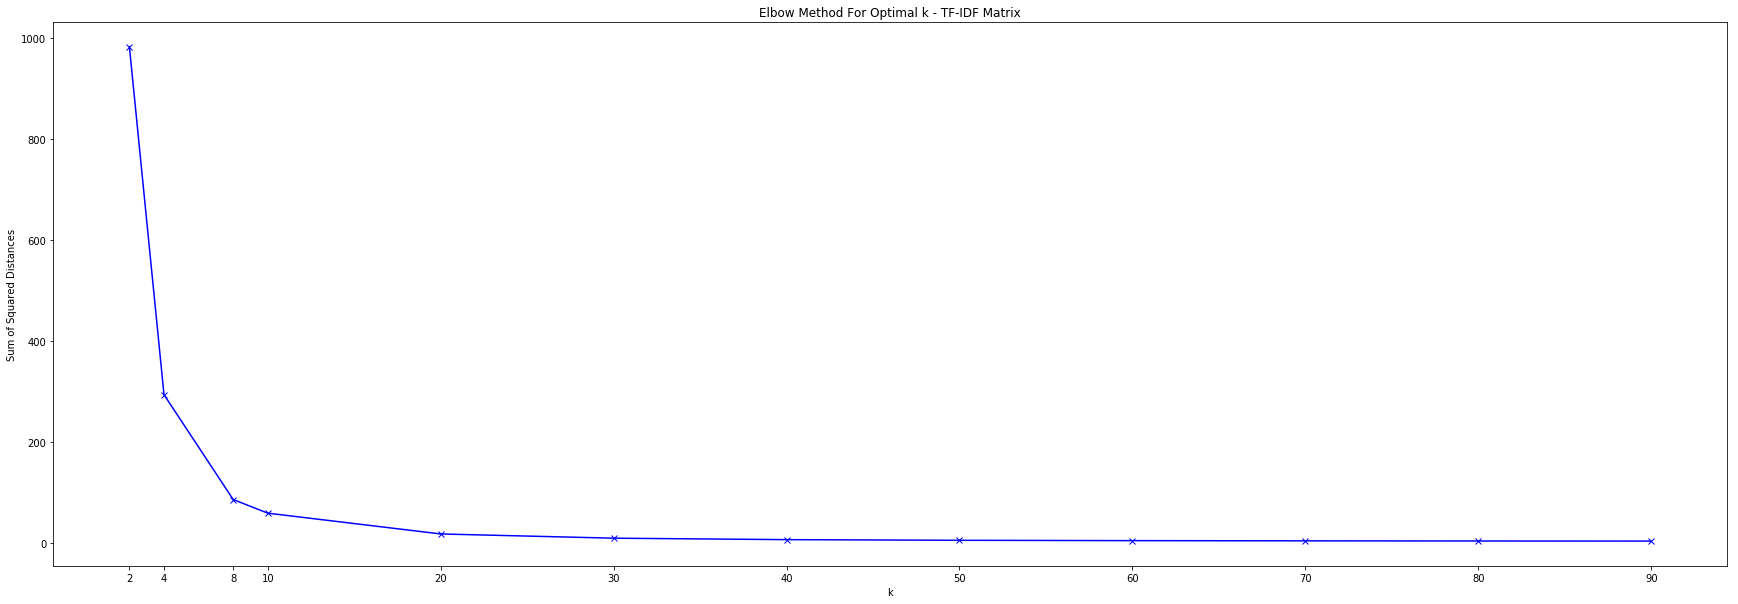

In [119]:
from data_science_toolkit.clustering import find_optimal_num_clusters
# tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, use_idf=True, tokenizer=tokenize_only, ngram_range=(1,5))
# tfidf_matrix = tfidf_vectorizer.fit_transform(since_election["preprocessed_text"].tolist()) #fit the vectorizer to synopses
find_optimal_num_clusters(model.docvecs.doctag_syn0, "TF-IDF Matrix", kmeans)

In [120]:
num_clusters = 8
km, labels, km.inertia_ = kmeans(num_clusters, model.docvecs.doctag_syn0)
# After finding using elbow method...
# joblib.dump(km,  'doc_cluster.pkl')
# km = joblib.load('doc_cluster.pkl')
# clusters = km.labels_.tolist()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  


In [121]:
labels.shape

(6190,)

In [122]:
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]
# for i in range(num_clusters):
#     top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
#     print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

In [124]:
from sklearn.metrics import pairwise_distances_argmin_min
doc_labels = km.labels_.tolist()
centers = np.array(km.cluster_centers_)
doc_vectors = model.docvecs.doctag_syn0.tolist()
center_distances = [np.linalg.norm(vec-centers[label]) for vec, label in zip(doc_vectors, doc_labels)]
len(center_distances)
#     center_distance = 
# center_distances = list(map(lambda x: np.linalg.norm(centers[]-)))
df = pd.DataFrame({"preprocessed_text": prep_tweets_since_election, 
                   "cluster": doc_labels, 
                   "vector": doc_vectors, 
                   "center_dist": center_distances})

for i in range(num_clusters):
    tmp = df[df["cluster"] == i]
    tmp = tmp.sort_values(by="center_dist", ascending=True)
    print("Most Common Words (Counter) in Cluster {}".format(i))
    print(Counter(filtered_word_array(' '.join(tmp['preprocessed_text'].tolist()))).most_common(5))
    print("Highest value TF-IDF Words in Cluster {}".format(i))
    vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, tokenizer=tokenize_only)
    X = vectorizer.fit_transform(tmp['preprocessed_text'].tolist())
    indices = np.argsort(vectorizer.idf_)[::-1]
    features = vectorizer.get_feature_names()
    top_n = 10
    top_features = [features[i] for i in indices[:top_n]]
    print(top_features)
    print("Tweets in Cluster {} with Lowest Centroid Distance:".format(i))
    print(tmp.head(10)[["center_dist", 'preprocessed_text']])
    print()
    print()
#     center_vec = centers[i]
#     dist = numpy.linalg.norm(a-b)
# clostest_data = []
# for i in range(num_clusters):
#     center_vec = centers[i]
#     data_idx_within_i_cluster = [ idx for idx, clu_num in enumerate(doc_labels) if clu_num == i ]
# #     print(data_idx_within_i_cluster)
#     one_cluster_tf_matrix = np.zeros( (  len(data_idx_within_i_cluster) , centers.shape[1] ) )
#     for row_num, data_idx in enumerate(data_idx_within_i_cluster):
#         one_row = tf_matrix[data_idx]
#         one_cluster_tf_matrix[row_num] = one_row

#     closest, _ = pairwise_distances_argmin_min(center_vec, one_cluster_tf_matrix)
#     closest_idx_in_one_cluster_tf_matrix = closest[0]
#     closest_data_row_num = data_idx_within_i_cluster[closest_idx_in_one_cluster_tf_matrix]
#     data_id = all_data[closest_data_row_num]

#     closest_data.append(data_id)

# closest_data = list(set(closest_data))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.


Most Common Words (Counter) in Cluster 0
[('tesla', 87), ('msciurl', 55), ('car', 47), ('model', 39), ('us', 27)]
Highest value TF-IDF Words in Cluster 0
["'re", 'open', 'orders', 'others', 'parts', 'pay', 'possible', 'data', 'customer', 'program']
Tweets in Cluster 0 with Lowest Centroid Distance:
      center_dist  \
1356  0.020300      
2402  0.020320      
3222  0.020685      
4061  0.020692      
1022  0.020770      
1005  0.020884      
1308  0.021100      
2718  0.021283      
3488  0.021401      
4493  0.022011      

                                                                                                                                                                                                                                                                              preprocessed_text  
1356  falcon fairing half as seen from our catcher ' s mitt in boat form , mr. steven . no apparent damage... msciurl                                                             

['market', 'might', 'shield', 'merlin', 'since', 'maybe', 'size', 'slightly', 'slow', 'fairing']
Tweets in Cluster 5 with Lowest Centroid Distance:
      center_dist  \
3858  0.020015      
6079  0.020758      
2282  0.021452      
3349  0.021580      
5950  0.021647      
3836  0.021701      
2895  0.021816      
1110  0.022356      
4103  0.022904      
1365  0.022924      

                                                                                                                                                                                                                                                                                     preprocessed_text  
3858  high probability of this particular rocket getting destroyed by dragon supersonic abort test . otherwise , at least 20 or 30 missions for falcon 9 . starship will take over before the f9 fleet reaches end of life .                                                                            
6079  spacex engine produc

In [ ]:
yikes

## 3.3 LDA for Topic Clustering - SKIPPING FOR NOW, SINCE IT'S NOT TECHNICALLY PART OF THE REPORT

This section focuses on using Latent Dirichlet Allocation (LDA) to learn yet more about the hidden structure within the top 100 film synopses. LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. There is quite a good high-level overview of probabilistic topic models by one of the big names in the field, David Blei, available in the Communications of the ACM here. Incidentally, Blei was one of the authors of the seminal paper on LDA.
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

HAD TO ADD THE WORD "GREAT" TO THE STOPWORD LIST BECAUSE IT WAS IN LITERALLY EVERY CLUSTER...

## NOTE THAT EVERY CLUSTERING THING WILL LIKELY HAVE SLIGHTLY DIFFERENT PREPROCESSING PARAMS!!!

In [ ]:
# Remove proper nouns (in this case get rid of all mentions)
# TRUMP ==============================================================================================================
# since_election['preprocessed_no_mentions'] = since_election['preprocessed_text'].apply(lambda tweet: ' '.join([w for w in tweet.split(' ') 
#                                                                                                                if w not in stop_words.union({'msciurl', 'twitpicture', 'great'}) 
#                                                                                                                and re.search('[a-zA-Z]', w)]))

# ELON MUSK ===========================================================================================================
# Remove proper nouns (in this case get rid of all mentions)
since_election['preprocessed_no_mentions'] = since_election['preprocessed_text'].apply(lambda tweet: ' '.join([w for w in tweet.split(' ') 
                                                                                                               if w not in stop_words.union({'msciurl', 'twitpicture', "'s'"}) 
                                                                                                               and re.search('[a-zA-Z]', w)]))

In [ ]:
texts = [[ting for ting in x.split(" ") if ting != ''] for x in since_election['preprocessed_no_mentions'].tolist()]
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.3)
# 0.21

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
coherence_scores = []
for i in range(2, 50, 2):
    lda = models.LdaMulticore(corpus, num_topics=i, 
                                id2word=dictionary, iterations=500)
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

In [ ]:
# coherence_scores

In [ ]:
plt.plot([x for x in range(2, 50, 2)], coherence_scores)
plt.ylabel("Coherence Scores")
plt.xlabel("Num Topics")

In [ ]:
lda_num_topics = 12

In [ ]:
lda = models.LdaMulticore(corpus, num_topics=lda_num_topics, iterations=500,
                                id2word=dictionary)

In [ ]:
lda.show_topics(num_topics=lda_num_topics)

- The area of circle represents the importance of each topic over the entire corpus
- The distance between the center of circles indicate the similarity between topics.
- Indices = sorted order by area
- Blue = overall term frequency
- Red = term freq within selected topic
- Lambda: trying to strike a balance between choosing general vs specific words (lambda=0 means super specific - exclusively popular for this topic)
- If some topics contain general words/feelings/sentiments

In [ ]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# df_dominant_topic.head(10)
df_dominant_topic['preprocessed_text'] = prep_tweets_since_election

In [ ]:
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda.show_topics(num_topics=lda_num_topics, formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

# print(lda.show_topics(num_topics=lda_num_topics, formatted=False))

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(' '.join)
df_top3words.reset_index(level=0,inplace=True)
df_top3words

In [ ]:
df = None
sample_size=5
for i in range(lda_num_topics):
    curr_cluster = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == i].sort_values(by='Topic_Perc_Contrib', ascending=False)
    if df is None:
        df = curr_cluster.head(sample_size)#.sample(n=min(sample_size, len(curr_cluster.index)-1))
    else:
        df = df.append(curr_cluster.head(sample_size))#curr_cluster.sample(n=min(sample_size, len(curr_cluster.index)-1)))
    df = df.append(pd.Series(), ignore_index=True)
df[["preprocessed_text", "Dominant_Topic", 'Topic_Perc_Contrib']]

# SAVE DATA (COMMENTED OUT)

In [ ]:
# lda.save('44_clusters_removed_great_lda.model')
# df.to_csv('lda_44_clusters_removed_great.csv', index=False)

# LDA VISUALIZATION (COMMENTED OUT)

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
vis

# 4.0 Distributions

## 4.1.1 Time of Day (Up vs Down)

In [ ]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["created_hour"], ax, 0, 0, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day (Above Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["created_hour"], ax, 0, 1, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day Since Election (Above Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["created_hour"], ax, 0, 0, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day (Below Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["created_hour"], ax, 0, 1, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day Since Election (Below Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)

## 4.2.1 Day of Week (Up vs Down)

In [ ]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["dow"], ax, 0, 0, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week (Above Monthly Average)", False, show_mean=False, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["dow"], ax, 0, 1, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week Since Election (Above Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["dow"], ax, 0, 0, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week (Below Monthly Average)", False, show_mean=False, show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["dow"], ax, 0, 1, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week Since Election (Below Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)

## 4.3 Num Retweets over Time

In [ ]:
from data_science_toolkit.file_ops import read_pkl
dt_avg = read_pkl("dt_avg_{}.pkl".format(file_name))

In [ ]:
avg_retweets, dates = [], []
for year in dt_avg:
    for month in dt_avg[year]:
        avg_retweets.append(dt_avg[year][month])
        dates.append(datetime(year, month, 1))
dates, avg_retweets = list(zip(*sorted(list(zip(dates, avg_retweets)), key=lambda x: x[0])))

# Average Number of Retweets per Month
- The average number of retweets Trump gets per month varies significantly, and also jumped during the middle of the year (around when he got elected)
- This makes comparing to a monthly average more appropriate

In [ ]:
fig = plt.figure(figsize=(30, 10))
plt.plot(dates, avg_retweets)
fig.suptitle('Monthly Retweet Average')
plt.xlabel('Year/Month')
plt.ylabel('Num Retweets')
plt.xticks(dates, [x.strftime('%m-%d-%Y') for x in dates], rotation=90)
plt.grid(True)
plt.show()

## 5.1 Tweet Anatomy

In [ ]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_words"], ax, 0, 0, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_words"], ax, 0, 1, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_words"], ax, 0, 0, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_words"], ax, 0, 1, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
# since_election[since_election.num_words > 55]

In [ ]:
set(stock_tweet[stock_tweet[output_col] == 0]['num_links'].tolist())

In [ ]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_links"], ax, 0, 0, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_links"], ax, 0, 1, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_links"], ax, 0, 0, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_links"], ax, 0, 1, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["percent_caps"], ax, 0, 0, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["percent_caps"], ax, 0, 1, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["percent_caps"], ax, 0, 0, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["percent_caps"], ax, 0, 1, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_hashtags"], ax, 0, 0, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_hashtags"], ax, 0, 1, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_hashtags"], ax, 0, 0, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_hashtags"], ax, 0, 1, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_mentions"], ax, 0, 0, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_mentions"], ax, 0, 1, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_mentions"], ax, 0, 0, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_mentions"], ax, 0, 1, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_videos"], ax, 0, 0, 
                        "Num Videos", "Tweets (%)", "Number of Tweets vs. Num Videos (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_videos"], ax, 0, 1, 
                        "Num Videos", "Tweets (%)", "Number of Tweets vs. Num Videos Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_videos"], ax, 0, 0, 
                        "Num Videos", "Tweets (%)", "Number of Tweets vs. Num Videos (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_videos"], ax, 0, 1, 
                        "Num Videos", "Tweets (%)", "Number of Tweets vs. Num Videos Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_photos"], ax, 0, 0, 
                        "Num Photos", "Tweets (%)", "Number of Tweets vs. Num Photos (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 1]["num_photos"], ax, 0, 1, 
                        "Num Photos", "Tweets (%)", "Number of Tweets vs. Num Photos Since Election (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 2, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_photos"], ax, 0, 0, 
                        "Num Photos", "Tweets (%)", "Number of Tweets vs. Num Photos (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
ax = generate_histogram(since_election[since_election[output_col] == 0]["num_photos"], ax, 0, 1, 
                        "Num Photos", "Tweets (%)", "Number of Tweets vs. Num Photos Since Election (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
# stock_tweet.head(10)

In [ ]:
# since_election.head(10)

## This is what we will be using for models...

In [ ]:
since_election.to_csv('./since_election_with_cluster_{}'.format(file_name), index=False)